# **Sentiment Analysis Model - TI2**
The goal of this project is to build a sentiment analysis model using supervised learning with vanilla Recurrent Neural Networks and LSTM.


## **Preprocess:**

Neceesary imports:

In [15]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import pandas as pd
# Necessary resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jc_be\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jc_be\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

English stopwords: 

In [16]:
stop_words = set(stopwords.words('english'))

Read the data into a pandas dataframe, where each row is a sentence and each column is a label (0 for negative, 1 for positive) and the text itself.

In [17]:
amazon_df = pd.read_csv('./sentiment labelled sentences/amazon_cells_labelled.txt', sep='\t',names=['sentence', 'tag'])

imdb_df = pd.read_csv('./sentiment labelled sentences/imdb_labelled.txt', sep='\t',names=['sentence', 'tag'])

yelp_df = pd.read_csv('./sentiment labelled sentences/yelp_labelled.txt', sep='\t',names=['sentence', 'tag'])

Tokenize and delete the stop words from text data  using NLTK:

- *word.isalnum()* ensures that only words containing alphabetic or numeric characters are included and excludes punctuation marks or other special characters.

In [18]:
stop_words = set(stopwords.words('english'))

# Tokenize and delete stop words from the Amazon sentences

amazon_df['tokens'] = amazon_df['sentence'].apply(lambda x: [word.lower() for word in word_tokenize(x) if word.isalnum() and word.lower() not in stop_words])


# Tokenize and delete stop words from the IMDB sentences
imdb_df['tokens'] = imdb_df['sentence'].apply(lambda x: [word.lower() for word in word_tokenize(x) if word.isalnum() and word.lower() not in stop_words])

# Tokenize and delete stop words from the Yelp sentences
yelp_df['tokens'] = yelp_df['sentence'].apply(lambda x: [word.lower() for word in word_tokenize(x) if word.isalnum() and word.lower() not in stop_words])


combined_sentiments_df = pd.concat([amazon_df, imdb_df, yelp_df], ignore_index=True)

## **Exploratory Data Analysis(EDA)**



Necessary imports:

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud


Firts 5 rows of the data:

In [24]:
combined_sentiments_df.head(5)

,sentence,tag,tokens
0,So there is no way for me to plug it in here i...,0,"[way, plug, us, unless, go, converter]"
1,"Good case, Excellent value.",1,"[good, case, excellent, value]"
2,Great for the jawbone.,1,"[great, jawbone]"
3,Tied to charger for conversations lasting more...,0,"[tied, charger, conversations, lasting, 45, pr..."
4,The mic is great.,1,"[mic, great]"


Dataset info:

In [25]:
combined_sentiments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2748 entries, 0 to 2747
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  2748 non-null   object
 1   tag       2748 non-null   int64 
 2   tokens    2748 non-null   object
dtypes: int64(1), object(2)
memory usage: 64.5+ KB


Verify if the dataset is balanced:

In [26]:
combined_sentiments_df.value_counts('tag')

tag
1    1386
0    1362
Name: count, dtype: int64

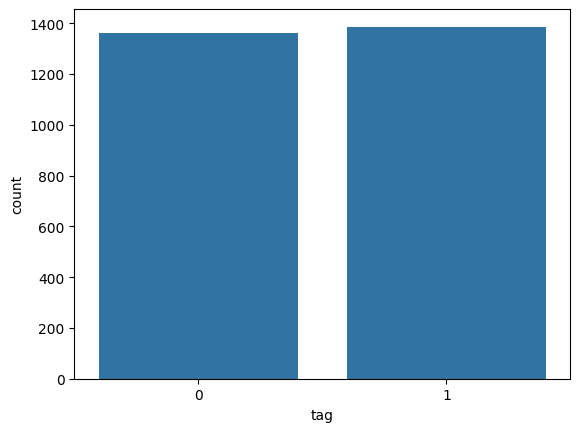

In [27]:
sns.countplot(x='tag',data=combined_sentiments_df,)
plt.show()

Wordcloud of positive and negative words (Amazon reviews):

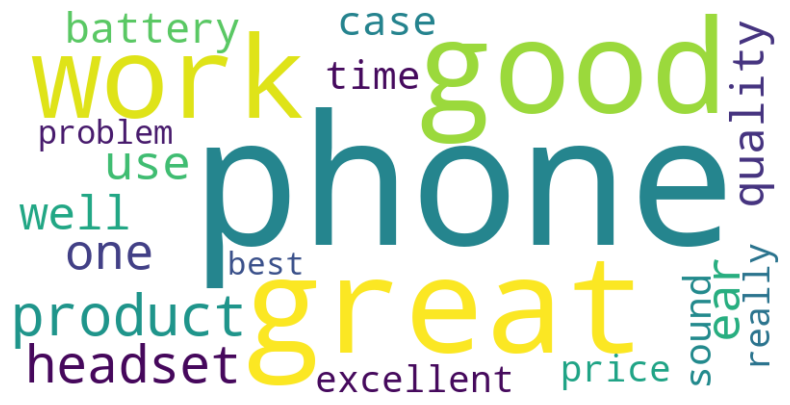

In [28]:

amazon_words =  [word for sublist in amazon_df['tokens'] for word in sublist]
amazon_text = ' '.join(amazon_words)

amazon_wc = WordCloud(width=800, height=400, max_words=20, background_color='white').generate(amazon_text)

plt.figure(figsize=(10, 5))
plt.imshow(amazon_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Wordcloud of positive and negative words (Imdb reviews):

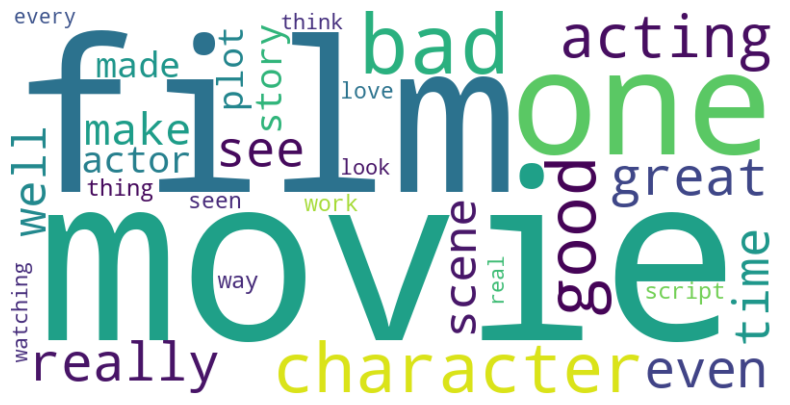

In [11]:
imdb_words =  [word for sublist in imdb_df['tokens'] for word in sublist]
imdb_text = ' '.join(imdb_words)

imdb_wc = WordCloud(width=800, height=400, max_words=30, background_color='white').generate(imdb_text)

plt.figure(figsize=(10, 5))
plt.imshow(imdb_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Wordcloud of positive and negative words (Imdb reviews):

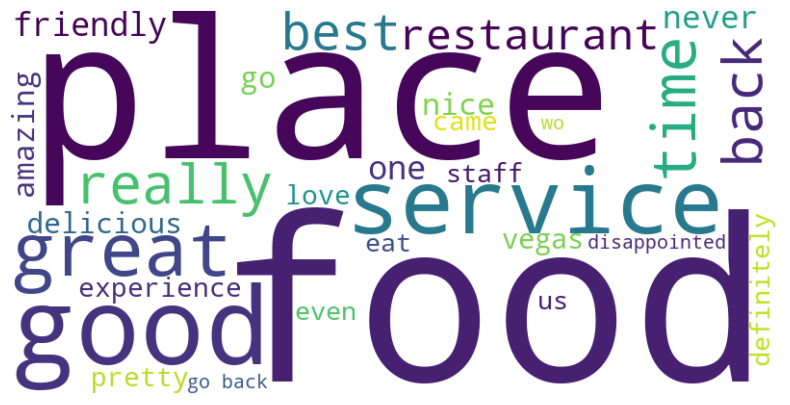

In [12]:
yelp_words =  [word for sublist in yelp_df['tokens'] for word in sublist]
yelp_text = ' '.join(yelp_words)

yelp_wc = WordCloud(width=800, height=400, max_words=30, background_color='white').generate(yelp_text)

plt.figure(figsize=(10, 5))
plt.imshow(yelp_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Wordcloud of positive and negative words (Combined reviews):

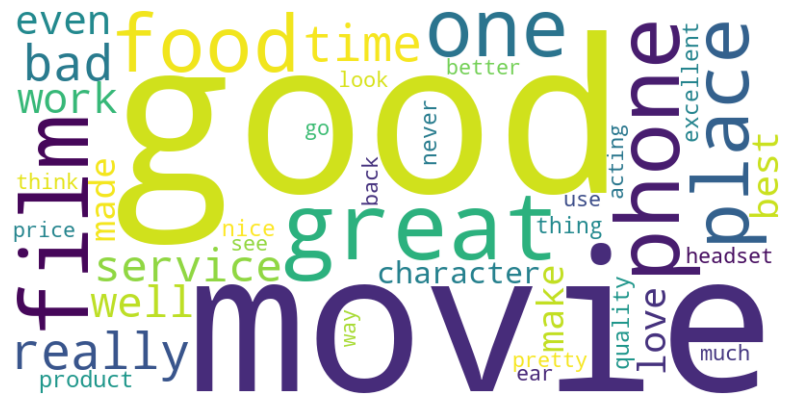

In [13]:
combined_sentiments_df

combined_sentiments_df_words =  [word for sublist in combined_sentiments_df['tokens'] for word in sublist]
combined_sentiments_df_text = ' '.join(combined_sentiments_df_words)

combined_sentiments_df_wc = WordCloud(width=800, height=400, max_words=40, background_color='white').generate(combined_sentiments_df_text)

plt.figure(figsize=(10, 5))
plt.imshow(combined_sentiments_df_wc, interpolation='bilinear')
plt.axis('off')
plt.show()


Split the data into train and test sets:

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(combined_sentiments_df['tokens'], combined_sentiments_df['tag'], test_size=0.3, random_state=42)

## **DummyClassifier**

Neceesary imports:

In [32]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


Build the DummyClassifier model:

In [33]:
clf_dummy = DummyClassifier(random_state=43,strategy='prior')
clf_dummy.fit(X_train, Y_train)

y_pred = clf_dummy.predict(X_test)

**Model performance**

*Accuracy*: is the fraction of predictions our model got right.

*Presicion*: is the fraction of positive predictions that are correct.

*Recaal*: is the fraction of the truly positive instances that the classifier recognizes.

*f1-score*: is the harmonic mean of precision and recall.

In [34]:
print(f'Accuracy: {accuracy_score(Y_test, y_pred)}')
print(f'Precision: {precision_score(Y_test, y_pred, average=None)}')
print(f'Recall: {recall_score(Y_test, y_pred, average=None)}')
print(f'F1: {f1_score(Y_test, y_pred, average=None)}')

Accuracy: 0.4727272727272727
Precision: [0.         0.47272727]
Recall: [0. 1.]
F1: [0.         0.64197531]


c:\Users\jc_be\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **RNN Model**	

Neceesary imports:

In [41]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN,Activation,Embedding
from keras import optimizers
from keras.utils import pad_sequences
from sklearn.model_selection import GridSearchCV
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor



Refactoring the model:

- Creating a Tokenizer object. Tokenizer is a Keras class used to convert text into sequences of tokens (words). This object will contain information about the vocabulary of the data set and will allow text to be transformed into sequences of integers.

In [42]:
# num_words = number of words to use, sorted by frequency
tokenizer = Tokenizer(num_words=1000,lower=True)

This method examines the text and builds the tokenizer's internal vocabulary, assigning a unique index to each word in the training set.

In [43]:
tokenizer.fit_on_texts(X_train)

Assigning each word in the vocabulary will be assigned a unique integer.



In [44]:
X_train_rnn = tokenizer.texts_to_sequences(X_train)

X_test_rnn = tokenizer.texts_to_sequences(X_test)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

print(f'Vocabulary size: {vocab_size}')

Vocabulary size: 4012


Processing the vocabulary:

In [45]:
# Padding the sentences to a maximum length
maxlen = 20

# All sentences must have the same length. Padding with 0.
X_train_rnn= pad_sequences(X_train_rnn, padding='post', maxlen=maxlen)
X_test_rnn = pad_sequences(X_test_rnn,padding='post', maxlen=maxlen)

Modifiying the input to be compatible with the input  of the RNN model:

In [46]:
X_train_rnn = np.array(X_train_rnn).reshape(X_train_rnn.shape[0],X_train_rnn.shape[1],1)

X_test_np = np.array(X_test_rnn).reshape(X_test_rnn.shape[0],X_test_rnn.shape[1],1)

Bulding the model:

In [48]:
def get_rnn(learning_rate=0.001,activation='sigmoid',metric='accuracy',dropout=0.01):
    # Binary classification Positive or Negative
    num_classes = 2

    # Model where layers are stacked sequentially
    model = Sequential()
    # Convert sequence of integers to sequence of dense vectors
    model.add(Embedding(vocab_size, 200, input_length=maxlen))

    model.add(SimpleRNN(200, input_shape=(maxlen,1),return_sequences=False))

    # Dropout layer to prevent overfitting
    model.add(Dropout(dropout))

    # Each neuron is connected to the before layer
    model.add(Dense(num_classes))
        
    # Produce ouputs between 0 and 1
    model.add(Activation(activation))

    model.summary()

    adam= optimizers.Adam(learning_rate)

    #Compile the model
    model.compile(loss='sparse_categorical_crossentropy',optimizer=adam,metrics=[metric])

    return model

model = KerasClassifier(build_fn=get_rnn, epochs=10, batch_size=64, verbose=1)


Training the model:

In [49]:
model.fit(X_train_rnn, Y_train)

y_pred = model.predict(X_test_np)

c:\Users\jc_be\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 200)           802400    
                                                                 
 simple_rnn (SimpleRNN)      (None, 200)               80200     
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 2)                 402       
                                                                 
 activation (Activation)     (None, 2)                 0         
                                                                 
Total params: 883002 (3.37 MB)
Trainable params: 883002 (3.37 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10


31/31 [

**Model performance**

*Accuracy*: is the fraction of predictions our model got right.

*Presicion*: is the fraction of positive predictions that are correct.

*Recaal*: is the fraction of the truly positive instances that the classifier recognizes.

*f1-score*: is the harmonic mean of precision and recall.

In [50]:
print(f'Accuracy: {accuracy_score(Y_test, y_pred)}')
print(f'Precision: {precision_score(Y_test, y_pred, average=None)}')
print(f'Recall: {recall_score(Y_test, y_pred, average=None)}')
print(f'F1: {f1_score(Y_test, y_pred, average=None)}')

Accuracy: 0.7248484848484849
Precision: [0.71399177 0.74041298]
Recall: [0.79770115 0.64358974]
F1: [0.75352877 0.68861454]


**Tuning the model**

In [51]:
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'activation': ['relu', 'sigmoid','softmax','tanh'],
    'metric': ['accuracy', 'mean_squared_error','cosine_proximity'],
    'dropout': [0.01,0.1,0.2]

}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
#grid_result = grid.fit(X_train_rnn, Y_train)

In [529]:
#print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}')

**Model with best score**

Model performance:

*Accuracy*: is the fraction of predictions our model got right.

*Presicion*: is the fraction of positive predictions that are correct.

*Recaal*: is the fraction of the truly positive instances that the classifier recognizes.

*f1-score*: is the harmonic mean of precision and recall.

In [52]:

def get_rnn(learning_rate=0.001,activation='softmax',metric='accuracy',dropout=0.01):
    # Binary classification Positive or Negative
    num_classes = 2

    # Model where layers are stacked sequentially
    model = Sequential()
    # Convert sequence of integers to sequence of dense vectors
    model.add(Embedding(vocab_size, 200, input_length=maxlen))

    model.add(SimpleRNN(200, input_shape=(maxlen,1),return_sequences=False))

    # Dropout layer to prevent overfitting
    model.add(Dropout(dropout))

    # Each neuron is connected to the before layer
    model.add(Dense(num_classes))
        
    # Produce ouputs between 0 and 1
    model.add(Activation(activation))

    model.summary()

    adam= optimizers.Adam(learning_rate)

    #Compile the model
    model.compile(loss='sparse_categorical_crossentropy',optimizer=adam,metrics=[metric])

    return model



new_model = KerasClassifier(build_fn=get_rnn, epochs=10, batch_size=64, verbose=1)

new_model.fit(X_train_rnn, Y_train)

y_pred = new_model.predict(X_test_np)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 200)           802400    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 200)               80200     
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 402       
                                                                 
 activation_1 (Activation)   (None, 2)                 0         
                                                                 
Total params: 883002 (3.37 MB)
Trainable params: 883002 (3.37 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10


c:\Users\jc_be\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


31/31 [==============================] - 1s 12ms/step - loss: 0.6605 - accuracy: 0.5777
Epoch 2/10
31/31 [==============================] - 0s 13ms/step - loss: 0.3768 - accuracy: 0.8409
Epoch 3/10
31/31 [==============================] - 0s 13ms/step - loss: 0.2133 - accuracy: 0.9236
Epoch 4/10
31/31 [==============================] - 0s 13ms/step - loss: 0.1388 - accuracy: 0.9459
Epoch 5/10
31/31 [==============================] - 0s 12ms/step - loss: 0.0919 - accuracy: 0.9646
Epoch 6/10
31/31 [==============================] - 0s 12ms/step - loss: 0.0864 - accuracy: 0.9678
Epoch 7/10
31/31 [==============================] - 0s 12ms/step - loss: 0.0836 - accuracy: 0.9730
Epoch 8/10
31/31 [==============================] - 0s 13ms/step - loss: 0.0901 - accuracy: 0.9652
Epoch 9/10
31/31 [==============================] - 0s 12ms/step - loss: 0.1026 - accuracy: 0.9589
Epoch 10/10
13/13 [==============================] - 0s 4ms/step


In [53]:
print(f'Accuracy: {accuracy_score(Y_test, y_pred)}')
print(f'Precision: {precision_score(Y_test, y_pred, average=None)}')
print(f'Recall: {recall_score(Y_test, y_pred, average=None)}')
print(f'F1: {f1_score(Y_test, y_pred, average=None)}')

Accuracy: 0.7042424242424242
Precision: [0.71753986 0.68911917]
Recall: [0.72413793 0.68205128]
F1: [0.7208238  0.68556701]


## **LSTM Model**	

Neceesary imports:

In [61]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN,Activation,Embedding
from keras import optimizers
from keras.utils import pad_sequences
from sklearn.model_selection import GridSearchCV
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor

In [62]:
# Creating a Tokenizer object
tokenizer = Tokenizer(num_words=1000, lower=True)
tokenizer.fit_on_texts(X_train)

X_train_lstm = tokenizer.texts_to_sequences(X_train)
X_test_lstm = tokenizer.texts_to_sequences(X_test)

# Padding the sentences to a maximum length
maxlen = 20
X_train_lstm = pad_sequences(X_train_lstm, padding='post', maxlen=maxlen)
X_test_lstm = pad_sequences(X_test_lstm, padding='post', maxlen=maxlen)

# Building the model
def get_lstm(learning_rate=0.001, activation='sigmoid', metric='accuracy', dropout=0.01):
    num_classes = 2

    model = Sequential()
    model.add(Embedding(vocab_size, 200, input_length=maxlen))
    model.add(LSTM(200, input_shape=(maxlen, 1), return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes))
    model.add(Activation(activation))

    model.summary()

    adam = optimizers.Adam(learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=[metric])

    return model

# Converting the input to be compatible with the LSTM model
X_train_lstm = np.array(X_train_lstm).reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], 1)
X_test_lstm = np.array(X_test_lstm).reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], 1)

# Creating the KerasClassifier
model = KerasClassifier(build_fn=get_lstm, epochs=10, batch_size=64, verbose=1)


Training the model:

In [63]:
# Training the model
model.fit(X_train_lstm, Y_train)

# Predicting on the test set
y_pred_lstm = model.predict(X_test_lstm)


c:\Users\jc_be\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 20, 200)           802400    
                                                                 
 lstm_2 (LSTM)               (None, 200)               320800    
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                                 
 dense_4 (Dense)             (None, 2)                 402       
                                                                 
 activation_4 (Activation)   (None, 2)                 0         
                                                                 
Total params: 1123602 (4.29 MB)
Trainable params: 1123602 (4.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
31/31

**Model performance**

Accuracy: is the fraction of predictions our model got right.

Presicion: is the fraction of positive predictions that are correct.

Recaal: is the fraction of the truly positive instances that the classifier recognizes.

f1-score: is the harmonic mean of precision and recall.

In [64]:
# Model performance
print(f'Accuracy: {accuracy_score(Y_test, y_pred_lstm)}')
print(f'Precision: {precision_score(Y_test, y_pred_lstm, average=None)}')
print(f'Recall: {recall_score(Y_test, y_pred_lstm, average=None)}')
print(f'F1: {f1_score(Y_test, y_pred_lstm, average=None)}')



Accuracy: 0.7345454545454545
Precision: [0.76470588 0.70503597]
Recall: [0.71724138 0.75384615]
F1: [0.74021352 0.72862454]


**Tuning the model**

In [65]:
# Tuning the model
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'activation': ['relu', 'sigmoid', 'softmax', 'tanh'],
    'metric': ['accuracy', 'mean_squared_error', 'cosine_proximity'],
    'dropout': [0.01, 0.1, 0.2]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
# grid_result = grid.fit(X_train_lstm, Y_train)
# print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}')


**Model with best score**

Model performance:

Accuracy: is the fraction of predictions our model got right.

Presicion: is the fraction of positive predictions that are correct.

Recaal: is the fraction of the truly positive instances that the classifier recognizes.

f1-score: is the harmonic mean of precision and recall.

In [66]:
# Model with the best score
def get_lstm_tuned(learning_rate=0.001, activation='softmax', metric='accuracy', dropout=0.01):
    num_classes = 2

    model = Sequential()
    model.add(Embedding(vocab_size, 200, input_length=maxlen))
    model.add(LSTM(200, input_shape=(maxlen, 1), return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes))
    model.add(Activation(activation))

    model.summary()

    adam = optimizers.Adam(learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=[metric])

    return model

# Creating a new KerasClassifier with the tuned parameters
new_model = KerasClassifier(build_fn=get_lstm_tuned, epochs=10, batch_size=64, verbose=1)

# Training the new model
new_model.fit(X_train_lstm, Y_train)

# Predicting on the test set with the tuned model
y_pred_lstm_tuned = new_model.predict(X_test_lstm)



Model: "sequential_5"


c:\Users\jc_be\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 20, 200)           802400    
                                                                 
 lstm_3 (LSTM)               (None, 200)               320800    
                                                                 
 dropout_5 (Dropout)         (None, 200)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 402       
                                                                 
 activation_5 (Activation)   (None, 2)                 0         
                                                                 
Total params: 1123602 (4.29 MB)
Trainable params: 1123602 (4.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
31/31 [====================

In [67]:
# Model performance with tuned parameters
print(f'Accuracy: {accuracy_score(Y_test, y_pred_lstm_tuned)}')
print(f'Precision: {precision_score(Y_test, y_pred_lstm_tuned, average=None)}')
print(f'Recall: {recall_score(Y_test, y_pred_lstm_tuned, average=None)}')
print(f'F1: {f1_score(Y_test, y_pred_lstm_tuned, average=None)}')

Accuracy: 0.7575757575757576
Precision: [0.74946921 0.76836158]
Recall: [0.81149425 0.6974359 ]
F1: [0.77924945 0.7311828 ]
